## nn 作って plasiticc で活かしたい
やること
 * 基本的な mlp 作成　& 性能調査
 * cnn 使った band 間の情報抽出

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

import torchvision
import torchvision.transforms as transforms


import matplotlib.pyplot as plt
import numpy as np

import numpy as np
import pandas as pd
from scipy.special import erfinv

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.preprocessing import StandardScaler
import lightgbm

from logging import getLogger
from tqdm import tqdm_notebook as tqdm
import argparse
import datetime
import random
from itertools import chain
import pickle
import warnings
from matplotlib import pyplot as plt
import seaborn as sns

import gc
import sys
from multiprocessing import Pool
sys.path.append('../')

from tools.my_logging import logInit
from tools.feature_tools import feature_engineering
from tools.objective_function import weighted_multi_logloss, lgb_multi_weighted_logloss, wloss_objective, wloss_metric, softmax, calc_team_score
from tools.model_io import save_models, load_models
from tools.fold_resampling import get_fold_resampling_dict

/home/naoya.taguchi/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
NTHREAD = 60
random.seed(71)
np.random.seed(42)
torch.manual_seed(71)
%load_ext autoreload
%autoreload 2

## nn の作成開始
まずは　mlp から。
 * ネットワーク構造、batchnorm の有無、drop out の値を　configurable に
 * cnn との連携を意識
 * 

In [3]:
class plasticcNet(nn.Module):
    def __init__(self, input_unit_num, mlp_unit_nums, band_cnn_idxes=None,
                init_do_rate=0., middle_do_rate=0.5, last_do_rate=0.25):
        super(plasticcNet, self).__init__()
        self.activation = torch.nn.ELU()
        self.cnn_activation = torch.nn.ELU()
        self.cnn_dropout = torch.nn.Dropout(p=0.2)
        self.cnn_dropout2 = torch.nn.Dropout(p=0.2)
        self.band_cnn_idxes = band_cnn_idxes
        self.init_do_rate = init_do_rate
        self.middle_do_rate = middle_do_rate
        self.last_do_rate = last_do_rate
         
        # band 軽特徴量間の幾何的構造に基づく関係性を捉える cnn 
        # 1st では poolig せず、second で　pooling する？
        self.maxpool1 = nn.MaxPool1d(kernel_size=3, stride=1)
        self.maxpool2 = nn.MaxPool1d(kernel_size=2, stride=1)
        self.band_conv_nets1 = nn.ModuleList()
        self.band_conv_nets2 = nn.ModuleList()
        self.band_batch_norm1 = nn.ModuleList()
        self.band_batch_norm2 = nn.ModuleList()
        #self.band_dropout1 = nn.ModuleList()
        #self.band_dropout2 = nn.ModuleList()
        if self.band_cnn_idxes:
            for band_cnn_idx in band_cnn_idxes:
                self.band_conv_nets1.append(
                    nn.Conv1d(
                        in_channels=1,
                        out_channels=1,
                        kernel_size=4,
                        stride=1)
                )
                #self.band_batch_norm1.append(nn.LayerNorm(6))
                self.band_batch_norm1.append(nn.BatchNorm1d(1))
                #self.band_dropout1.append()
                self.band_conv_nets2.append(
                    nn.Conv1d(
                        in_channels=1,
                        out_channels=1,
                        kernel_size=3,
                        stride=1)
                )
                #self.band_batch_norm2.append(nn.LayerNorm(4))
                self.band_batch_norm2.append(nn.BatchNorm1d(1))
                #self.band_dropout2.append()
            None
       
        # mlp を組む
        # 一層目の unit num を作る
        if self.band_cnn_idxes:
            self.unpacked_band_cnn_idxes = list(chain.from_iterable(self.band_cnn_idxes))
            #past_unit_num = input_unit_num + len(self.unpacked_band_cnn_idxes) // 6 * 4 - len(self.unpacked_band_cnn_idxes) # only 1 layer
            #past_unit_num = input_unit_num + len(self.unpacked_band_cnn_idxes) // 6 * 6 - len(self.unpacked_band_cnn_idxes) # only 1 layer
            self.cnn_out_unit_num = len(self.unpacked_band_cnn_idxes) // 6 * 4
            self.cnn_bn = nn.LayerNorm(self.cnn_out_unit_num)
            #self.cnn_bn = nn.BatchNorm1d(self.cnn_out_unit_num)
            past_unit_num = input_unit_num + self.cnn_out_unit_num - len(self.unpacked_band_cnn_idxes) # w/o pooling
            #past_unit_num = input_unit_num + len(self.unpacked_band_cnn_idxes) // 6 * 3 - len(self.unpacked_band_cnn_idxes)
        else:
            past_unit_num = input_unit_num
        self.dense_nets = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        for i, mlp_unit_num in enumerate(mlp_unit_nums):
            self.dense_nets.append(nn.Linear(past_unit_num, mlp_unit_num))
            self.batch_norms.append(nn.BatchNorm1d(mlp_unit_num))
            if i == 0:
                p = self.init_do_rate
            elif i == len(mlp_unit_nums) - 1:
                p = self.last_do_rate
            else:
                p = self.middle_do_rate
            self.dropouts.append(nn.Dropout(p=p))
            past_unit_num = mlp_unit_num
            
    def forward(self, x):
        batch_size = x.shape[0]
        x_cnns = []
        if len(self.band_conv_nets1) > 0:
            for zipped in zip(self.band_cnn_idxes, 
                            self.band_conv_nets1, self.band_batch_norm1, 
                            self.band_conv_nets2, self.band_batch_norm2):
                band_cnn_idx, band_conv_net1, band_batch_norm1, band_conv_net2, band_batch_norm2 = zipped
                x_cnn = x[:, band_cnn_idx]
                x_cnn = torch.cat([x_cnn, x_cnn[:,:3]], dim=1) # mod
                x_cnn = x_cnn.view(batch_size, 1, -1) 
                x_cnn = band_conv_net1(x_cnn) 
                x_cnn = self.cnn_activation(x_cnn)
                x_cnn = band_batch_norm1(x_cnn)
                x_cnn = self.cnn_dropout(x_cnn)
                #x_cnn = self.maxpool1(x_cnn)
                x_cnn = band_conv_net2(x_cnn) 
                x_cnn = self.cnn_activation(x_cnn)
                #x_cnn = band_batch_norm2(x_cnn)
                #x_cnn = self.cnn_dropout(x_cnn)
                #x_cnn = self.maxpool2(x_cnn)
                x_cnns.append(x_cnn)

            x_cnns = torch.cat(x_cnns, dim=1).view(batch_size, -1) # concat して channel を押しつぶす
            x_cnns = self.cnn_bn(x_cnns)
            x_cnns = self.cnn_dropout2(x_cnns)
            x = np.delete(x, self.unpacked_band_cnn_idxes, axis=1) # drop used idxes  self.unpacked....
            x = torch.cat([x, x_cnns], dim=1) 
        else:
            x = x
        for i, nets in enumerate(list(zip(self.dense_nets, self.batch_norms, self.dropouts))):
            dense_net, batch_norm, dropout = nets
            if i < len(self.dense_nets) - 1:
                x = dropout(x)
                x = dense_net(x)
                x = self.activation(x)
                x = batch_norm(x)
            else:
                x = dropout(x)
                x =  dense_net(x)
                #x = batch_norm(x)
                #x = dropout(x)
        return x

In [4]:
m = nn.MaxPool1d(3, stride=1)
m2 = nn.MaxPool1d(2, stride=1)
n = nn.Conv1d(in_channels=1,out_channels=1,kernel_size=3,stride=1)
n2 = nn.Conv1d(in_channels=1,out_channels=1,kernel_size=3,stride=1)
n3 = nn.Conv1d(in_channels=1,out_channels=1,kernel_size=4,stride=1)

input = torch.randn(100, 8)
input = input.view(input.shape[0], 1, input.shape[1])
print(n3(input).shape)
print(n(input).shape)
print(m(n(input)).shape)
print(n2(m(n(input))).shape)
print(m2(n2(m(n(input)))).shape)
print('aa')
print(m2(n2(n(input))).shape)
print('aa')
print(m2(n2(n(input))).shape)
print('aa')
print(n2(n(input)).shape)
print('aa')

b = nn.BatchNorm1d(1)
print(n(input).shape)
print(b(n(input)).shape)

torch.Size([100, 1, 5])
torch.Size([100, 1, 6])
torch.Size([100, 1, 4])
torch.Size([100, 1, 2])
torch.Size([100, 1, 1])
aa
torch.Size([100, 1, 3])
aa
torch.Size([100, 1, 3])
aa
torch.Size([100, 1, 4])
aa
torch.Size([100, 1, 6])
torch.Size([100, 1, 6])


In [5]:
torch.cat([torch.randn(100, 8), torch.randn(100, 8)], dim=1).shape

torch.Size([100, 16])

#### とりあえずネットワークはできたので loss を定義して学習させてみる

In [6]:
# feature を作る
logger = getLogger(__name__)
logInit(logger, log_dir='../log/', log_filename='notebook.log')

training_set_df = pd.read_csv('/home/naoya.taguchi/.kaggle/competitions/PLAsTiCC-2018/training_set.csv')
training_set_metadata_df = pd.read_csv('/home/naoya.taguchi/.kaggle/competitions/PLAsTiCC-2018/training_set_metadata.csv')
train_df = feature_engineering(
        training_set_df,
        training_set_metadata_df,
        nthread=NTHREAD,
        logger=logger)

2018-11-30 02:51:03,478 __main__             727 [INFO] [feature_engineering] getting split dfs ... 
2018-11-30 02:51:03,480 __main__             39 [INFO] [split_dfs] calculating uniq object_id num 
2018-11-30 02:51:03,497 __main__             41 [INFO] [split_dfs] getting groups 
2018-11-30 02:51:03,498 __main__             43 [INFO] [split_dfs] splitting df 
100%|██████████| 60/60 [00:05<00:00, 10.48it/s]
2018-11-30 02:51:09,229 __main__             734 [INFO] [feature_engineering] adding corrected flux... 
60it [00:05, 11.46it/s]
2018-11-30 02:51:14,469 __main__             739 [INFO] [feature_engineering] start fature engineering ... 
Feature Extraction: 100%|██████████| 300/300 [00:02<00:00, 100.67it/s]
2018-11-30 02:51:41,334 __main__             774 [INFO] [feature_engineering] post processing ... 
INFO:__main__:post processing ...


In [6]:
# 欠損率計算関数
def get_null_stat(df):
    whole_num = df.shape[0]
    res_list = []
    for col in df.columns:
        res_list.append([col, df[df[col].isnull()].shape[0]/whole_num])
    return pd.DataFrame(res_list).rename(columns={0: 'column', 1: 'null_rat'})

In [7]:
# 欠損値が多い... とりあえず　mean で埋めるか...
null_df = get_null_stat(train_df).sort_values('null_rat', ascending=False)
null_df[null_df.null_rat != 0]

,column,null_rat
97,band-1_std_upper_mjd_skew,0.712538
70,band-0_std_upper_mjd_skew,0.630097
100,band-1_std_upper_flux_diff_mean,0.438328
98,band-1_std_upper_mjd_diff_mean,0.438328
96,band-1_std_upper_mjd_var,0.438328
151,band-3_std_upper_mjd_skew,0.424439
124,band-2_std_upper_mjd_skew,0.424057
224,5_minus_0_wmean,0.313583
69,band-0_std_upper_mjd_var,0.307849
73,band-0_std_upper_flux_diff_mean,0.307849


In [7]:
# inf の変換
train_df = train_df.replace(np.inf, np.nan)
train_df = train_df.replace(-np.inf, np.nan)
#train_df = train_df.fillna(train_df.mean())#.drop(null_df[null_df.null_rat != 0]['column'], axis=1)

In [8]:
# test df の　load, inf の変換
test_df = pd.read_feather('../test_dfs/test_df_for_nn.fth')
test_df = test_df.replace(np.inf, np.nan)
test_df = test_df.replace(-np.inf, np.nan)
test_df

,level_0,hostgal_photoz_err,distmod,lumi_dist,index,flux_min,flux_max,flux_mean,flux_median,flux_std,...,4__longest_strike_above_mean,4__longest_strike_below_mean,4__mean_abs_change,4__mean_change,5__length,5__longest_strike_above_mean,5__longest_strike_below_mean,5__mean_abs_change,5__mean_change,internal
0,0,0.0542,41.1123,1.669014e+09,0,-12.680235,42.765503,3.997127,0.616561,9.149645,...,16.0,35.0,4.073720,0.485154,51.0,15.0,9.0,7.615641,0.159762,False
1,1,0.0179,42.8774,3.762530e+09,1,-11.142164,14.839427,0.884047,0.072856,3.399946,...,10.0,6.0,2.881917,-0.077381,51.0,5.0,8.0,6.203901,0.095968,False
2,2,0.0605,43.6000,5.248075e+09,2,-14.202744,16.761280,0.791032,0.458391,3.886578,...,11.0,5.0,2.902001,0.155380,57.0,10.0,3.0,7.105358,0.379122,False
3,3,0.1479,42.9640,3.915615e+09,3,-12.631923,28.061138,0.970396,0.465986,4.100713,...,10.0,9.0,2.898105,0.025145,51.0,6.0,5.0,7.853819,0.255055,False
4,4,0.0122,42.0540,2.575135e+09,4,-13.239577,124.475609,4.580070,0.301366,19.862714,...,5.0,29.0,6.365985,-0.032805,57.0,5.0,11.0,9.064352,-0.117800,False
5,5,0.0375,43.6290,5.318633e+09,5,-9.032743,34.847000,1.800237,0.589795,5.726820,...,11.0,15.0,3.650384,0.026436,51.0,10.0,10.0,6.801373,0.124411,False
6,6,0.0546,43.0186,4.015319e+09,6,-10.711065,23.771006,0.533671,0.096750,3.428601,...,9.0,5.0,3.884788,0.004700,55.0,6.0,7.0,6.646113,0.045079,False
7,7,0.0529,45.1281,1.060767e+10,7,-21.568415,12.179604,0.012805,0.009715,3.409948,...,5.0,7.0,3.372349,-0.017008,55.0,6.0,4.0,8.100708,-0.350190,False
8,8,0.0116,43.9519,6.171347e+09,8,-21.433050,28.675814,1.480276,0.087896,6.017310,...,11.0,18.0,3.076622,-0.081591,57.0,14.0,9.0,7.927046,-0.125916,False
9,9,0.1092,44.2138,6.962417e+09,9,-14.229353,35.446308,1.388202,0.398017,5.941994,...,8.0,8.0,4.080947,0.133456,57.0,7.0,9.0,7.153272,-0.046974,False


In [80]:
# feature selection 
drop_feats = [
 'hostgal_photoz_err',
 'distmod',
 'lumi_dist',
 'flux_min',
 'flux_max',
 'flux_mean',
 'flux_median',
 'flux_std',
 'flux_var',
 'flux_skew',
 'flux_count',
 'flux_kurtosis',
 'corrected_flux_min',
 'corrected_flux_max',
 'corrected_flux_mean',
 'corrected_flux_median',
 'corrected_flux_std',
 'corrected_flux_var',
 'corrected_flux_skew',
 'flux_err_min',
 'flux_err_max',
 'flux_err_mean',
 'flux_err_median',
 'flux_err_std',
 'flux_err_var',
 'flux_err_skew',
 'flux_err_kurtosis',
 'flux_ratio_to_flux_err_min',
 'flux_ratio_to_flux_err_max',
 'detected_mean',
 'flux_ratio_sq_skew',
 'flux_ratio_sq_mean',
 'flux_ratio_sq_kurtosis',
 'flux_by_flux_ratio_sq_sum',
 'flux_by_flux_ratio_sq_skew',
 'corrected_flux_ratio_sq_sum',
 'corrected_flux_ratio_sq_skew',
 'corrected_flux_by_flux_ratio_sq_sum',
 'corrected_flux_by_flux_ratio_sq_skew',
 'std_upper_mjd_get_max_min_diff',
 'std_upper_mjd_var',
 'std_upper_mjd_skew',
 'std_upper_flux_count',
 'std_upper_flux_min',
 'detected_mjd_get_max_min_diff',
 'detected_mjd_skew',
 'flux_diff',
 'flux_dif2',
 'flux_w_mean',
 'flux_dif3',
 'corrected_flux_diff',
 'corrected_flux_dif2',
 'corrected_flux_w_mean',
 'corrected_flux_dif3',
 'std_upper_rat',
 'passband_flux_min_var',
 'passband_flux_means_var',
 'passband_flux_counts_var',
 'passband_detected_means_var',
 'band_flux_diff_max',
 'band_flux_diff_min',
 'band_flux_diff_diff',
 'band_flux_diff_diff_rat',
 'band_flux_max_min_rat',
 'internal',
]

band_cnn_columns_list = [
    [f'band-{i}_wmean' for i in range(6)],
    [f'band-{i}_normed_std' for i in range(6)],
    [f'band-{i}_normed_amp' for i in range(6)],
    [f'band-{i}_normed_mad' for i in range(6)],
    [f'band-{i}_beyond_1std' for i in range(6)],
    [f'band-{i}_flux_var' for i in range(6)],
    [f'band-{i}_flux_skew' for i in range(6)],
    [f'band-{i}_flux_kurtosis' for i in range(6)],
    [f'band-{i}_flux_quantile10' for i in range(6)],
    [f'band-{i}_flux_quantile25' for i in range(6)],
    [f'band-{i}_flux_quantile75' for i in range(6)],
    [f'band-{i}_flux_quantile90' for i in range(6)],
    [f'band-{i}_flux_quantile2575_range' for i in range(6)],
    [f'band-{i}_flux_quantile1090_range' for i in range(6)],
    [f'band-{i}_normed_flux_diff_mean' for i in range(6)],
    [f'band-{i}_detected_mean' for i in range(6)],
    [f'band-{i}_flux_ratio_sq_sum' for i in range(6)],
    [f'band-{i}_flux_ratio_sq_skew' for i in range(6)],
    [f'band-{i}_flux_by_flux_ratio_sq_sum' for i in range(6)],
    [f'band-{i}_flux_by_flux_ratio_sq_skew' for i in range(6)],
    [f'band-{i}_flux_diff' for i in range(6)],
    [f'band-{i}_std_upper_mjd_get_max_min_diff' for i in range(6)],
    [f'band-{i}_std_upper_mjd_var' for i in range(6)],
    [f'band-{i}_std_upper_mjd_skew' for i in range(6)],
    [f'band-{i}_std_upper_mjd_diff_mean' for i in range(6)],
    [f'band-{i}_std_upper_flux_count' for i in range(6)],
    [f'band-{i}_std_upper_flux_diff_mean' for i in range(6)],
    [f'{i}_minus_{(i+1)%6}_wmean' for i in range(6)],
    [f'{i}_minus_{(i+1)%6}_std' for i in range(6)],
    [f'{i}_minus_{(i+1)%6}_amp' for i in range(6)],
    [f'{i}__length' for i in range(6)],
    [f'{i}__longest_strike_above_mean' for i in range(6)],
    [f'{i}__longest_strike_below_mean' for i in range(6)],
    [f'{i}__mean_abs_change' for i in range(6)],
    [f'{i}__mean_change' for i in range(6)],
]

drop_feats += list(chain.from_iterable(band_cnn_columns_list))

In [81]:
# array にする
#x_train = train_df.drop('target', axis=1).values
#x_test = test_df.drop('index', axis=1).values
x_train = train_df[drop_feats].values
x_test = test_df[drop_feats].values

In [82]:
x_train_and_test = np.concatenate([x_train, x_test], axis=0)
x_train_and_test

array([[0.0, nan, nan, ..., 13.479509859649134, 10.955700245614038,
        9.160124642857133],
       [0.2552, 45.4063, 12057575777.884813, ..., -0.3079447090909091,
        -0.19398805454545454, -0.3854395818181818],
       [0.0157, 40.2561, 1125174807.987472, ..., -0.03120339215686279,
        -0.09061540000000011, 0.22623755999999992],
       ...,
       [0.0093, 38.7604, 565041049.6341876, ..., 0.08252927272727124,
        0.2500318823529408, 0.5582540930232562],
       [0.2616, 41.8625, 2357762195.9612474, ..., 0.8446168,
        0.4793897241379314, -0.5051059],
       [0.7335, 41.4333, 1934906573.2494402, ..., 0.029096217391304312,
        0.5915539200000002, 1.7494450937500012]], dtype=object)

In [11]:
class GaussRankScaler():

    def __init__(self):
        self.epsilon = 0.001
        self.lower = -1 + self.epsilon
        self.upper = 1 - self.epsilon
        self.range = self.upper - self.lower
        
    def fit_transform(self, X):

        i = np.argsort(X, axis=0)
        j = np.argsort(i, axis=0)

        assert (j.min() == 0).all()
        assert (j.max() == len(j) - 1).all()

        j_range = len(j) - 1
        self.divider = j_range / self.range

        transformed = j / self.divider
        transformed = transformed - self.upper
        transformed = erfinv(transformed)

        return transformed
    
def continuousNormalization(target_df, scaler):
    for column in tqdm(target_df.columns.values):
        # minmax normalization for continuous data
        if target_df[column].dtype != 'object' and column != 'target':
            if target_df[column].max() > 0:
                target_df[column] = \
                    scaler.fit_transform(target_df[column])
    return target_df    

def continuousNormalizationForArray(target_array, scaler):
    for idx in tqdm(range(target_array.shape[1])):
        target_array[:,idx] = scaler.fit_transform(target_array[:,idx])
        # minmax normalization for continuous data
    return target_array
    
#scaler = GaussRankScaler()    
#train_df = continuousNormalization(train_df, scaler)
    
#scaler = GaussRankScaler()    
#train_df = continuousNormalization(train_df, scaler)

In [13]:
scaler = GaussRankScaler()
def get_scaled_train(idx):
    #scaler = GaussRankScaler()
    #scaler.fit(x_train[:,idx])
    #scaler.fit(x_train_and_test[:,idx])
    #print(scaler.divider)
    return {idx: scaler.fit_transform(x_train[:,idx])}

def get_scaled_test(idx):
    #scaler.fit(x_train[:,idx])
    #scaler.fit(x_train_and_test[:,idx])
    #print(scaler.devider)
    return {idx: scaler.fit_transform(x_test[:,idx])}

def get_scaled_train_and_test(idx):
    return {idx: scaler.fit_transform(x_train_and_test[:,idx])}

In [83]:
# scaling して scaled_x_train, scaled_x_test に分ける
with Pool(NTHREAD) as p:
    scaled_train_and_test_list = p.map(get_scaled_train_and_test, [i for i in range(x_train_and_test.shape[1])])
    p.close()
    p.join()
gc.collect()    

# 各々の値を挿入
for scaled_train_and_test in tqdm(scaled_train_and_test_list):
    idx =list(scaled_train_and_test.keys())[0] 
    value = list(scaled_train_and_test.values())[0]
    x_train_and_test[:, idx] = value
x_train_and_test = x_train_and_test.astype(np.double)    

# train, test に split
x_train_scaled = x_train_and_test[:x_train.shape[0],:]
x_test_scaled = x_train_and_test[x_train.shape[0]:,:]

HBox(children=(IntProgress(value=0, max=275), HTML(value='')))

In [84]:
# 欠損値埋め
x_train_scaled = pd.DataFrame(x_train_scaled).fillna(0.).values
x_test_scaled = pd.DataFrame(x_test_scaled).fillna(0.).values

In [16]:
from torchvision import transforms

def worker_init_fn(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)

class plasticcDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x.astype(np.float32))
#        self.y = torch.from_numpy(y.astype(np.float32))
        self.y = torch.LongTensor(y.astype(np.float32))
        #self.y = y
#        self.transform = transforms.Compose([transforms.ToTensor()])
 
    def __len__(self):
        return self.x.shape[0]
 
    def __getitem__(self, idx):
        return self.x[idx, :], self.y[idx]

In [17]:
# objective
# y_h に nan が起こりうる -> classsize が　0 になりうるのでどうにかせねば...
# 
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
def wloss_metric(preds, train_data):
    weight_tensor = torch.tensor(np.array(list(class_weight.values())).astype(np.float), requires_grad=True).type(torch.FloatTensor)
    #weight_tensor = torch.tensor(list(class_weight.values()), requires_grad=True).type(torch.FloatTensor)
    y_t = torch.tensor(train_data, requires_grad=True).type(torch.LongTensor)
    y_h = torch.zeros(y_t.shape[0], len(classes), requires_grad=True).scatter(1, y_t.reshape(-1, 1), 1)
    print(y_t.shape)
    y_h[y_h == 0] = 1
    y_h /= y_h.sum(dim=0, keepdim=True)
    y_p = torch.tensor(preds, requires_grad=True).type(torch.FloatTensor)
    if len(y_p.shape) == 1:
        y_p = y_p.reshape(len(classes), -1).transpose(0, 1)
    ln_p = torch.log_softmax(y_p, dim=1)
    wll = torch.sum(y_h * ln_p, dim=0)
    loss = -torch.dot(weight_tensor, wll) / torch.sum(weight_tensor)
    return loss

def mywloss(y_pred_raw, y_true):  
    weight_tensor = torch.tensor(np.array(list(class_weight.values())).astype(np.float), requires_grad=True).type(torch.FloatTensor)
    y_onehot = torch.FloatTensor(y_true.shape[0], len(classes))
    y_onehot.zero_()
    y_onehot.scatter_(1, y_true.reshape(-1, 1), 1)
    
    y_pred_log=torch.log_softmax(y_pred_raw, dim=1)
    class_num = torch.sum(y_onehot, dim=0)
    class_num[class_num == 0] = 1
    loss=-(torch.mean(torch.sum(torch.sum(y_onehot*y_pred_log, dim=0)*weight_tensor/class_num) / torch.sum(weight_tensor)))
    return loss

def get_l2_loss(model, weight=0.1):
    l2_weight = torch.tensor(weight)
    l2_reg = torch.tensor(0.)
    for param in model.parameters():
        l2_reg += torch.norm(param)
    return l2_weight * l2_reg

def calc_team_score(y_true, y_preds):
    '''
    y_true:$B#1<!85$N(Bnp.array
    y_pred:softmax$B8e$N#1(B4$B<!85$N(Bnp.array
    '''
    y_preds =  torch.softmax(y_preds, dim=1).detach().numpy()
    
    class99_prob = 1/9
    class99_weight = 2
            
    y_p = y_preds * (1-class99_prob)
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    y_p_log = np.log(y_p)
    
    y_true_ohe = pd.get_dummies(y_true).values
    nb_pos = y_true_ohe.sum(axis=0).astype(float)
    
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    
    y_log_ones = np.sum(y_true_ohe * y_p_log, axis=0)
    y_w = y_log_ones * class_arr / nb_pos
    score = - np.sum(y_w) / (np.sum(class_arr)+class99_weight)\
        + (class99_weight/(np.sum(class_arr)+class99_weight))*(-np.log(class99_prob))

    return score

In [18]:
# cnn に突っ込むように col から idx にかえる関数作成
def _get_idxes_from_columns(df, columns):
    return np.where(np.isin(df.columns.tolist(), columns))

def convert_columns_to_indexes(df, columns_list):
    indexes = [_get_idxes_from_columns(df, cols)[0] for cols in columns_list]
    return indexes

In [24]:
train_df.columns.tolist()

['hostgal_photoz_err',
 'distmod',
 'target',
 'lumi_dist',
 'index',
 'flux_min',
 'flux_max',
 'flux_mean',
 'flux_median',
 'flux_std',
 'flux_var',
 'flux_skew',
 'flux_count',
 'flux_kurtosis',
 'corrected_flux_min',
 'corrected_flux_max',
 'corrected_flux_mean',
 'corrected_flux_median',
 'corrected_flux_std',
 'corrected_flux_var',
 'corrected_flux_skew',
 'flux_err_min',
 'flux_err_max',
 'flux_err_mean',
 'flux_err_median',
 'flux_err_std',
 'flux_err_var',
 'flux_err_skew',
 'flux_err_kurtosis',
 'flux_ratio_to_flux_err_min',
 'flux_ratio_to_flux_err_max',
 'detected_mean',
 'flux_ratio_sq_skew',
 'flux_ratio_sq_mean',
 'flux_ratio_sq_kurtosis',
 'flux_by_flux_ratio_sq_sum',
 'flux_by_flux_ratio_sq_skew',
 'corrected_flux_ratio_sq_sum',
 'corrected_flux_ratio_sq_skew',
 'corrected_flux_by_flux_ratio_sq_sum',
 'corrected_flux_by_flux_ratio_sq_skew',
 'std_upper_mjd_get_max_min_diff',
 'std_upper_mjd_var',
 'std_upper_mjd_skew',
 'std_upper_flux_count',
 'std_upper_flux_min',
 

In [85]:
#band_cnn_idxes = convert_columns_to_indexes(train_df.drop(drop_feats + ['target'], axis=1), band_cnn_columns_list)
band_cnn_idxes = convert_columns_to_indexes(train_df[drop_feats], band_cnn_columns_list)
band_cnn_idxes, len(band_cnn_idxes)

([array([65, 66, 67, 68, 69, 70]),
  array([71, 72, 73, 74, 75, 76]),
  array([77, 78, 79, 80, 81, 82]),
  array([83, 84, 85, 86, 87, 88]),
  array([89, 90, 91, 92, 93, 94]),
  array([ 95,  96,  97,  98,  99, 100]),
  array([101, 102, 103, 104, 105, 106]),
  array([107, 108, 109, 110, 111, 112]),
  array([113, 114, 115, 116, 117, 118]),
  array([119, 120, 121, 122, 123, 124]),
  array([125, 126, 127, 128, 129, 130]),
  array([131, 132, 133, 134, 135, 136]),
  array([137, 138, 139, 140, 141, 142]),
  array([143, 144, 145, 146, 147, 148]),
  array([149, 150, 151, 152, 153, 154]),
  array([155, 156, 157, 158, 159, 160]),
  array([161, 162, 163, 164, 165, 166]),
  array([167, 168, 169, 170, 171, 172]),
  array([173, 174, 175, 176, 177, 178]),
  array([179, 180, 181, 182, 183, 184]),
  array([185, 186, 187, 188, 189, 190]),
  array([191, 192, 193, 194, 195, 196]),
  array([197, 198, 199, 200, 201, 202]),
  array([203, 204, 205, 206, 207, 208]),
  array([209, 210, 211, 212, 213, 214]),
  arr

In [86]:
label_num = 14
FOLD_NUM = 5
DO_RATE = 0.5

torch.manual_seed(71)

le = LabelEncoder()
le.fit(train_df['target'].values)

# remove features
#pd.read_csv
feats_df = pd.read_csv('../importances/Booster_weight-multi-logloss-0.579991_2018-11-20-13-16-50_importance.csv')

x_train = x_train_scaled
#x_train = train_df.drop('target', axis=1).values
#x_train = train_df.drop(list(feats_df.feature.tolist())[:170], axis=1).drop('target', axis=1).values.astype(np.double)
y_train = le.transform(train_df.target)

#ss = StandardScaler()
#x_train = ss.fit_transform(x_train)
#scaler = GaussRankScaler()    
#x_train = scaler.fit_transform(x_train)
#for res in reses:
#    idx =list(res.keys())[0] 
#    value = list(res.values())[0]
#    x_train[:, idx] = value
#x_train = x_train.astype(np.double)    
#x_train = continuousNormalizationForArray(x_train, scaler)
#x_train = np.nan_to_num(x_train)
#x_train = pd.DataFrame(x_train).fillna(x_train.mean()).values

skf = StratifiedKFold(n_splits=FOLD_NUM, shuffle=True, random_state=71)
folds = skf.split(x_train, y_train)
#max_layer_size = 1024
#max_layer_size = 756
#max_layer_size = 2048
#max_layer_size = 4096
max_layer_size = 512
#max_layer_size = 128
#max_layer_size = 64
#max_layer_size = 256


best_models = []
best_scores = []
best_team_scores = []
best_losses = []
for trn_idx, val_idx in tqdm(list(folds)):
    x_trn, x_val = x_train[trn_idx], x_train[val_idx]
    y_trn, y_val = y_train[trn_idx], y_train[val_idx]

    #mlp_unit_nums = (max_layer_size, max_layer_size//2, max_layer_size//4,  label_num)
    mlp_unit_nums = (max_layer_size, max_layer_size//2, 50, max_layer_size//4, max_layer_size//8, label_num)

    pnn = plasticcNet(input_unit_num=x_trn.shape[1], mlp_unit_nums=mlp_unit_nums, init_do_rate=DO_RATE*0.0, middle_do_rate=DO_RATE, last_do_rate=DO_RATE*0.5)
    #pnn = plasticcNet(input_unit_num=x_trn.shape[1], mlp_unit_nums=mlp_unit_nums, 
    #                  band_cnn_idxes=band_cnn_idxes, init_do_rate=DO_RATE*0.0, middle_do_rate=DO_RATE, last_do_rate=DO_RATE*0.5)
    optimizer = optim.SGD(pnn.parameters(), lr=0.6, momentum=0.0)
    #optimizer = optim.ASGD(pnn.parameters(), lr=0.3,  )
    #optimizer = optim.Adam(pnn.parameters(), lr=0.01, weight_decay=0.)
    #optimizer = optim.RMSprop(pnn.parameters(), lr=0.01, momentum=0.)   
    #scheduler = StepLR(optimizer, step_size=3, gamma=0.7)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.6)
    #scheduler = StepLR(optimizer, step_size=10, gamma=0.6)
        
    dataset = plasticcDataset(x_trn, y_trn)
    dataloader = DataLoader(dataset, batch_size=100, shuffle=True, num_workers=0, worker_init_fn=worker_init_fn)

    epochs = 1000
    losses = []
    best_val = 100000000
    best_count = 0
    best_model = None   
    
    for epoch in range(epochs):
        scheduler.step()
        for i_batch, sample_batched in enumerate(dataloader):
            pnn = pnn.train()
            optimizer.zero_grad()
            x_trn_batch, y_trn_batch = sample_batched
            _res = pnn(x_trn_batch)
            loss = mywloss(_res, y_trn_batch)
            loss.backward()
            optimizer.step()
            losses.append(loss.detach().numpy())
            #break
        pnn = pnn.eval()
        val_res = pnn(torch.Tensor(x_val))
        val_score = mywloss(val_res, torch.LongTensor(y_val)).detach().numpy()
        val_team_score = calc_team_score(y_val, val_res)
        if epoch % 1 == 0:
            if best_val > val_score:
                best_epoch = epoch
                best_val = val_score
                best_team_val = val_team_score
                best_loss = np.mean(losses)
                best_count = 0
                torch.save(pnn.state_dict(), '../check_points/temp.pth')
            else:
                best_count += 1
            print(f'epoch : {epoch}', f'lr: {optimizer.state_dict()["param_groups"][0]["lr"]:.5f}', f'train_loss : {np.mean(losses):.5f}', f'val_loss : {val_score:.5f}', f'akiyama-metric{best_team_val:.5f}')
            losses = []
            if best_count >= 30:
                print(f'best epoch: {best_epoch}', f'best training loss {best_loss:.5f}', f'best val: {best_val:.5f}', f'best team val: {best_team_val:.5f}')
                pnn.load_state_dict(torch.load('../check_points/temp.pth'))
                best_models.append(pnn)
                best_val_res = pnn(torch.Tensor(x_val))
                best_scores.append(best_val)
                best_team_scores.append(best_team_val)
                best_losses.append(best_loss)
                gc.collect()
                break
        # break
#    break

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

epoch : 0 lr: 0.60000 train_loss : 1.64808 val_loss : 1.32958 akiyama-metric1.53068
epoch : 1 lr: 0.60000 train_loss : 1.29492 val_loss : 1.09515 akiyama-metric1.32230
epoch : 2 lr: 0.60000 train_loss : 1.15601 val_loss : 1.04197 akiyama-metric1.27503
epoch : 3 lr: 0.60000 train_loss : 1.07623 val_loss : 1.04977 akiyama-metric1.27503
epoch : 4 lr: 0.60000 train_loss : 1.02526 val_loss : 0.99701 akiyama-metric1.23506
epoch : 5 lr: 0.36000 train_loss : 0.94217 val_loss : 0.95456 akiyama-metric1.19733
epoch : 6 lr: 0.36000 train_loss : 0.92140 val_loss : 0.88136 akiyama-metric1.13226
epoch : 7 lr: 0.36000 train_loss : 0.87374 val_loss : 0.88519 akiyama-metric1.13226
epoch : 8 lr: 0.36000 train_loss : 0.85460 val_loss : 0.89330 akiyama-metric1.13226
epoch : 9 lr: 0.36000 train_loss : 0.89357 val_loss : 0.84654 akiyama-metric1.10132
epoch : 10 lr: 0.21600 train_loss : 0.86264 val_loss : 0.84169 akiyama-metric1.09700
epoch : 11 lr: 0.21600 train_loss : 0.81933 val_loss : 0.84189 akiyama-metr

epoch : 3 lr: 0.60000 train_loss : 1.10424 val_loss : 0.88007 akiyama-metric1.13112
epoch : 4 lr: 0.60000 train_loss : 1.05545 val_loss : 0.82820 akiyama-metric1.08501
epoch : 5 lr: 0.36000 train_loss : 1.00162 val_loss : 0.81675 akiyama-metric1.07483
epoch : 6 lr: 0.36000 train_loss : 0.95583 val_loss : 0.77695 akiyama-metric1.03945
epoch : 7 lr: 0.36000 train_loss : 0.90278 val_loss : 0.77531 akiyama-metric1.03800
epoch : 8 lr: 0.36000 train_loss : 0.89041 val_loss : 0.76161 akiyama-metric1.02582
epoch : 9 lr: 0.36000 train_loss : 0.91152 val_loss : 0.75241 akiyama-metric1.01764
epoch : 10 lr: 0.21600 train_loss : 0.87614 val_loss : 0.74308 akiyama-metric1.00935
epoch : 11 lr: 0.21600 train_loss : 0.82868 val_loss : 0.72432 akiyama-metric0.99267
epoch : 12 lr: 0.21600 train_loss : 0.82487 val_loss : 0.73067 akiyama-metric0.99267
epoch : 13 lr: 0.21600 train_loss : 0.79580 val_loss : 0.71801 akiyama-metric0.98707
epoch : 14 lr: 0.21600 train_loss : 0.79215 val_loss : 0.71308 akiyama-m

epoch : 23 lr: 0.07776 train_loss : 0.76296 val_loss : 0.76097 akiyama-metric1.02525
epoch : 24 lr: 0.07776 train_loss : 0.73905 val_loss : 0.75598 akiyama-metric1.02082
epoch : 25 lr: 0.04666 train_loss : 0.73466 val_loss : 0.76204 akiyama-metric1.02082
epoch : 26 lr: 0.04666 train_loss : 0.72300 val_loss : 0.75808 akiyama-metric1.02082
epoch : 27 lr: 0.04666 train_loss : 0.74659 val_loss : 0.75769 akiyama-metric1.02082
epoch : 28 lr: 0.04666 train_loss : 0.71379 val_loss : 0.76588 akiyama-metric1.02082
epoch : 29 lr: 0.04666 train_loss : 0.72429 val_loss : 0.76151 akiyama-metric1.02082
epoch : 30 lr: 0.02799 train_loss : 0.73045 val_loss : 0.75609 akiyama-metric1.02082
epoch : 31 lr: 0.02799 train_loss : 0.73595 val_loss : 0.75900 akiyama-metric1.02082
epoch : 32 lr: 0.02799 train_loss : 0.72132 val_loss : 0.75252 akiyama-metric1.01774
epoch : 33 lr: 0.02799 train_loss : 0.71558 val_loss : 0.75423 akiyama-metric1.01774
epoch : 34 lr: 0.02799 train_loss : 0.69805 val_loss : 0.74925 ak

epoch : 45 lr: 0.00605 train_loss : 0.69629 val_loss : 0.77213 akiyama-metric1.03517
epoch : 46 lr: 0.00605 train_loss : 0.69807 val_loss : 0.77670 akiyama-metric1.03517
epoch : 47 lr: 0.00605 train_loss : 0.70350 val_loss : 0.78132 akiyama-metric1.03517
epoch : 48 lr: 0.00605 train_loss : 0.70326 val_loss : 0.78246 akiyama-metric1.03517
epoch : 49 lr: 0.00605 train_loss : 0.70235 val_loss : 0.77689 akiyama-metric1.03517
epoch : 50 lr: 0.00363 train_loss : 0.71464 val_loss : 0.77852 akiyama-metric1.03517
epoch : 51 lr: 0.00363 train_loss : 0.70080 val_loss : 0.77430 akiyama-metric1.03517
epoch : 52 lr: 0.00363 train_loss : 0.68101 val_loss : 0.78042 akiyama-metric1.03517
epoch : 53 lr: 0.00363 train_loss : 0.67394 val_loss : 0.78094 akiyama-metric1.03517
epoch : 54 lr: 0.00363 train_loss : 0.67648 val_loss : 0.77734 akiyama-metric1.03517
epoch : 55 lr: 0.00218 train_loss : 0.70397 val_loss : 0.77545 akiyama-metric1.03517
epoch : 56 lr: 0.00218 train_loss : 0.68895 val_loss : 0.77738 ak

epoch : 27 lr: 0.04666 train_loss : 0.72412 val_loss : 0.86347 akiyama-metric1.10843
epoch : 28 lr: 0.04666 train_loss : 0.69000 val_loss : 0.86967 akiyama-metric1.10843
epoch : 29 lr: 0.04666 train_loss : 0.69789 val_loss : 0.86357 akiyama-metric1.10843
epoch : 30 lr: 0.02799 train_loss : 0.69991 val_loss : 0.86040 akiyama-metric1.10843
epoch : 31 lr: 0.02799 train_loss : 0.70464 val_loss : 0.85617 akiyama-metric1.10843
epoch : 32 lr: 0.02799 train_loss : 0.69436 val_loss : 0.85636 akiyama-metric1.10843
epoch : 33 lr: 0.02799 train_loss : 0.68650 val_loss : 0.85650 akiyama-metric1.10843
epoch : 34 lr: 0.02799 train_loss : 0.70950 val_loss : 0.85686 akiyama-metric1.10843
epoch : 35 lr: 0.01680 train_loss : 0.70004 val_loss : 0.85662 akiyama-metric1.10843
epoch : 36 lr: 0.01680 train_loss : 0.70306 val_loss : 0.86577 akiyama-metric1.10843
epoch : 37 lr: 0.01680 train_loss : 0.69597 val_loss : 0.86156 akiyama-metric1.10843
epoch : 38 lr: 0.01680 train_loss : 0.68032 val_loss : 0.86912 ak

In [137]:
# 0.5, 512
print(best_scores)
np.mean(best_scores)

[array(0.65579784, dtype=float32), array(0.5790213, dtype=float32), array(0.6531416, dtype=float32), array(0.70015186, dtype=float32), array(0.75002456, dtype=float32)]


0.66762745

In [15]:
# 0.5, 512
print(best_scores)
np.mean(best_scores)

[array(0.74130976, dtype=float32), array(0.6293675, dtype=float32), array(0.8167837, dtype=float32), array(0.7839532, dtype=float32), array(0.78325003, dtype=float32)]


0.7509328

In [28]:
# 0.5, 1024
print(best_scores)
np.mean(best_scores)

[array(0.6371915, dtype=float32), array(0.57337964, dtype=float32), array(0.688722, dtype=float32), array(0.6422246, dtype=float32), array(0.7261095, dtype=float32)]


0.6535255

In [273]:
# mlp best
print(best_scores)
print(best_losses)
np.mean(best_scores), np.mean(best_losses)

[array(0.6335573, dtype=float32), array(0.58966523, dtype=float32), array(0.6589908, dtype=float32), array(0.6628199, dtype=float32), array(0.7260165, dtype=float32)]
[0.43064398, 0.46263605, 0.44748816, 0.4763766, 0.5250671]


(0.65421, 0.46844238)

In [276]:
# cnn best
print(best_scores)
print(best_losses)
np.mean(best_scores), np.mean(best_losses)

[array(0.62816554, dtype=float32), array(0.5317673, dtype=float32), array(0.6296488, dtype=float32), array(0.59902394, dtype=float32), array(0.69439536, dtype=float32)]
[0.46677956, 0.4612369, 0.49128667, 0.49626023, 0.49006426]


(0.61660016, 0.48112553)

In [303]:
# cnn w/o pooling, 3, 3
print(best_scores)
print(best_losses)
np.mean(best_scores), np.mean(best_losses)

[array(0.62578785, dtype=float32), array(0.5281287, dtype=float32), array(0.6097816, dtype=float32), array(0.6296424, dtype=float32), array(0.65423214, dtype=float32)]
[0.46120185, 0.48285073, 0.49248827, 0.49760926, 0.5670449]


(0.60951453, 0.500239)

In [306]:
# 1 layer cnn 
print(best_scores)
print(best_losses)
np.mean(best_scores), np.mean(best_losses)

[array(0.62714696, dtype=float32), array(0.5373625, dtype=float32), array(0.64250916, dtype=float32), array(0.6018097, dtype=float32), array(0.7017313, dtype=float32)]
[0.56369936, 0.4801942, 0.43745452, 0.46748066, 0.5725211]


(0.622112, 0.50426996)

In [39]:
# cnn w/ kernel 4, 3
print(best_scores)
print(best_team_scores)
print(best_losses)
np.mean(best_team_scores), np.mean(best_scores), np.mean(best_losses)

[array(0.6042922, dtype=float32), array(0.5262122, dtype=float32), array(0.62952024, dtype=float32), array(0.5854798, dtype=float32), array(0.66508156, dtype=float32)]
[0.8859808192468017, 0.8165762551046125, 0.908405640126795, 0.8692586136386078, 0.9400157705857872]
[0.4920624, 0.44207063, 0.50777864, 0.46594292, 0.53493917]


(0.8840474197405209, 0.6021172, 0.48855877)

In [331]:
# cnn w/ kernel 5, 3
print(best_scores)
print(best_losses)
np.mean(best_scores), np.mean(best_losses)

[array(0.6044886, dtype=float32), array(0.52956176, dtype=float32), array(0.64363384, dtype=float32), array(0.58462214, dtype=float32), array(0.66079235, dtype=float32)]
[0.46584064, 0.462694, 0.5134587, 0.5078794, 0.47111166]


(0.60461974, 0.48419684)

In [54]:
# test
print(best_scores)
print(best_losses)
np.mean(best_scores), np.mean(best_losses)

[array(0.6174747, dtype=float32), array(0.53093946, dtype=float32), array(0.633431, dtype=float32), array(0.59542894, dtype=float32), array(0.6669039, dtype=float32)]
[0.5087129, 0.4977209, 0.5026919, 0.51976, 0.53415227]


(0.6088356, 0.51260763)

In [41]:
# past best
print(best_scores)
print(best_team_scores)
print(best_losses)
np.mean(best_team_scores), np.mean(best_scores), np.mean(best_losses)

[array(0.662494, dtype=float32), array(0.6185911, dtype=float32), array(0.69608545, dtype=float32), array(0.65367883, dtype=float32), array(0.7288982, dtype=float32)]
[0.9377155709491589, 0.8986908267741069, 0.9675748210462887, 0.9298799853394866, 0.9967415452371495]
[0.56922305, 0.55426306, 0.5405021, 0.5867293, 0.7013868]


(0.9461205498692381, 0.6719495, 0.59042084)

In [58]:
# cnn 512, 256, 128, 64, 14
print(best_scores)
print(best_team_scores)
print(best_losses)
np.mean(best_team_scores), np.mean(best_scores), np.mean(best_losses)

[array(0.6516894, dtype=float32), array(0.53758454, dtype=float32), array(0.65119714, dtype=float32), array(0.63028795, dtype=float32), array(0.7115344, dtype=float32)]
[0.9281116871058268, 0.8266850691556058, 0.9276740180711704, 0.9090880962498638, 0.9813070870464919]
[0.60067344, 0.5716018, 0.5612851, 0.5367023, 0.6019259]


(0.9145731915257918, 0.6364587, 0.57443774)

In [66]:
# cnn 512, 256, 128, 64, 14 w/ cnn dropout
print(best_scores)
print(best_team_scores)
print(best_losses)
np.mean(best_team_scores), np.mean(best_scores), np.mean(best_losses)

[array(0.66469914, dtype=float32), array(0.5411829, dtype=float32), array(0.6289903, dtype=float32), array(0.63072324, dtype=float32), array(0.6761239, dtype=float32)]
[0.9396757848120649, 0.8298834531651602, 0.9079345907677214, 0.9094749739422878, 0.9498311531171053]
[0.65301824, 0.6234896, 0.572607, 0.65519065, 0.58494973]


(0.907359991160868, 0.62834394, 0.6178511)

In [114]:
# cnn 1024, 512, 256, 128, 14, w/ dropout 
print(best_scores)
print(best_team_scores)
print(best_losses)
np.mean(best_team_scores), np.mean(best_scores), np.mean(best_losses)

[array(0.6560034, dtype=float32), array(0.56884676, dtype=float32), array(0.64443886, dtype=float32), array(0.6474388, dtype=float32), array(0.6740941, dtype=float32)]
[0.9319462857103933, 0.8544737341662278, 0.9216666198632013, 0.9243331780697004, 0.948026803634491]
[0.63183284, 0.62555796, 0.59617263, 0.6250186, 0.66627944]


(0.9160893242888027, 0.6381644, 0.62897223)

In [58]:
# cnn 1024, 512, 256, 128, 14, w/ dropout 
print(best_scores)
print(best_team_scores)
print(best_losses)
np.mean(best_team_scores), np.mean(best_scores), np.mean(best_losses)

[array(0.6516894, dtype=float32), array(0.53758454, dtype=float32), array(0.65119714, dtype=float32), array(0.63028795, dtype=float32), array(0.7115344, dtype=float32)]
[0.9281116871058268, 0.8266850691556058, 0.9276740180711704, 0.9090880962498638, 0.9813070870464919]
[0.60067344, 0.5716018, 0.5612851, 0.5367023, 0.6019259]


(0.9145731915257918, 0.6364587, 0.57443774)

In [161]:
# cnn 1024, 512, 256, 128, 14, w/ fixed network
print(best_scores)
print(best_team_scores)
print(best_losses)
np.mean(best_team_scores), np.mean(best_scores), np.mean(best_losses)

[array(0.643443, dtype=float32), array(0.5514233, dtype=float32), array(0.639753, dtype=float32), array(0.62757814, dtype=float32), array(0.66991645, dtype=float32)]
[0.9207814306043718, 0.8389860100264397, 0.9175015194469456, 0.9066791812452439, 0.9443133170392681]
[0.6406552, 0.66282254, 0.621985, 0.6624712, 0.6336029]


(0.9056522916724538, 0.62642276, 0.6443074)

In [173]:
# cnn 1024, 512, 256, 128, 14, w/ fixed network
print(best_scores)
print(best_team_scores)
print(best_losses)
np.mean(best_team_scores), np.mean(best_scores), np.mean(best_losses)

[array(0.65316176, dtype=float32), array(0.5309262, dtype=float32), array(0.6292069, dtype=float32), array(0.64088106, dtype=float32), array(0.68568295, dtype=float32)]
[0.9294203606717204, 0.8207664659406035, 0.9081271709935306, 0.9185041564104695, 0.9583279519863579]
[0.6061607, 0.6108873, 0.6179479, 0.6009742, 0.6136498]


(0.9070292212005363, 0.62797177, 0.60992396)

In [22]:
# new features mlp
print(best_scores)
print(best_team_scores)
print(best_losses)
np.mean(best_team_scores), np.mean(best_scores), np.mean(best_losses)

[array(0.6939845, dtype=float32), array(0.6022243, dtype=float32), array(0.70099604, dtype=float32), array(0.66926813, dtype=float32), array(0.75929224, dtype=float32)]
[0.9657071975774136, 0.884142531398989, 0.9719397093782467, 0.943737117423, 1.0237585123749042]
[0.6105962, 0.6369813, 0.6311598, 0.61378276, 0.6335208]


(0.9578570136305107, 0.685153, 0.62520814)

In [25]:
# new features cnn
print(best_scores)
print(best_team_scores)
print(best_losses)
np.mean(best_team_scores), np.mean(best_scores), np.mean(best_losses)

[array(0.669745, dtype=float32), array(0.5502137, dtype=float32), array(0.65407693, dtype=float32), array(0.60945827, dtype=float32), array(0.69643176, dtype=float32)]
[0.9441610322953331, 0.8379109716865327, 0.9302339001584321, 0.8905726879831324, 0.9678826179453377]
[0.6485231, 0.6245236, 0.60511917, 0.6103744, 0.63780975]


(0.9141522420137536, 0.6359852, 0.62527)

In [61]:
# new features cnn dropped
print(best_scores)
print(best_team_scores)
print(best_losses)
np.mean(best_team_scores), np.mean(best_scores), np.mean(best_losses)

[array(0.666501, dtype=float32), array(0.58878624, dtype=float32), array(0.6524138, dtype=float32), array(0.6220138, dtype=float32), array(0.6616962, dtype=float32)]
[0.9412774132080366, 0.8721975726775739, 0.9287554022168147, 0.9017331667069002, 0.9370063281334429]
[0.6413475, 0.6692035, 0.62445825, 0.6548105, 0.63235015]


(0.9161939765885535, 0.6382822, 0.644434)

In [69]:
# new features mlp
print(best_scores)
print(best_team_scores)
print(best_losses)
np.mean(best_team_scores), np.mean(best_scores), np.mean(best_losses)

[array(0.66952705, dtype=float32), array(0.61336505, dtype=float32), array(0.70329976, dtype=float32), array(0.6404138, dtype=float32), array(0.7611306, dtype=float32)]
[0.9439673532608466, 0.8940454643468028, 0.9739874833640458, 0.9180888089007833, 1.0253925584250074]
[0.57227445, 0.585237, 0.57986385, 0.58646375, 0.6024817]


(0.9510963336594971, 0.6775473, 0.5852641)

In [79]:
# new features mlp dropped
print(best_scores)
print(best_team_scores)
print(best_losses)
np.mean(best_team_scores), np.mean(best_scores), np.mean(best_losses)

[array(0.99781907, dtype=float32), array(0.9615289, dtype=float32), array(0.99982893, dtype=float32), array(1.0229225, dtype=float32), array(1.0588863, dtype=float32)]
[1.2357823785560296, 1.2035244640689282, 1.2375687735574779, 1.2580965991301696, 1.290064357744102]
[0.90011203, 0.85651165, 0.8789339, 0.8571245, 0.8061088]


(1.2450073146113414, 1.0081972, 0.8597582)

#### test を適用してみる

In [174]:
test_reses = []
for bpnn in tqdm(best_models):
    # torch の nn の出力を ↑　の自作 softmax でさばくと nan ができてしまう
    test_reses.append(torch.nn.functional.softmax(bpnn(torch.Tensor(x_test_scaled))).detach().numpy())
    #test_reses.append(softmax(bpnn(torch.Tensor(x_test_scaled)).detach().numpy()))
    # test_reses.append(lgb.predict_proba(x_test_scaled, raw_score=False))

res = np.clip(np.mean(test_reses, axis=0), 10**(-15), 1 - 10**(-15))
preds_99 = np.ones((res.shape[0]))
for i in range(res.shape[1]):
    preds_99 *= (1 - res[:, i])
preds_99 = 0.14 * preds_99 / np.mean(preds_99)
#res *= 8/9
#preds_99 = 1/9

# res = np.concatenate((res, preds_99), axis=1)
# res = np.concatenate((res, np.zeros((res.shape[0], 1))), axis=1)
logger.info('now creating the submission file ...')
res_df = pd.DataFrame(res, columns=[
    'class_6',
    'class_15',
    'class_16',
    'class_42',
    'class_52',
    'class_53',
    'class_62',
    'class_64',
    'class_65',
    'class_67',
    'class_88',
    'class_90',
    'class_92',
    'class_95',
    #                'class_99',
])
res_df['class_99'] = preds_99
#submission_file_name = '../submissions/PLASTICC_NET_weight-multi-logloss-{:.6}.csv'\
#    .format(trained_models[0].__class__.__name__,
#            np.mean(best_scores))
#logger.info(
#    'saving the test result to {}'.format(submission_file_name))
#pd.concat([object_ids, res_df], axis=1)\
#    .to_csv(submission_file_name, index=False)

100%|██████████| 5/5 [27:21<00:00, 328.24s/it]
2018-11-28 11:24:55,185 __main__             18 [INFO] [<module>] now creating the submission file ... 


In [165]:
object_ids = pd.read_csv('/home/naoya.taguchi/.kaggle/competitions/PLAsTiCC-2018/test_set_metadata.csv').object_id
submission_file_name = '../submissions/PLASTICC_NET_weight-multi-logloss-{:.6}.csv'.format(np.mean(best_scores))
logger.info(
    'saving the test result to {}'.format(submission_file_name))
pd.concat([object_ids, res_df], axis=1)\
    .to_csv(submission_file_name, index=False)

2018-11-28 10:12:05,948 __main__             4 [INFO] [<module>] saving the test result to ../submissions/PLASTICC_NET_weight-multi-logloss-0.626423.csv 


#### appendix

In [ ]:
null_df = get_null_stat(res_df).sort_values('null_rat', ascending=False)
#null_df = get_null_stat(pd.DataFrame(test_reses[0].detach().numpy())).sort_values('null_rat', ascending=False)
null_df[null_df.null_rat != 0]

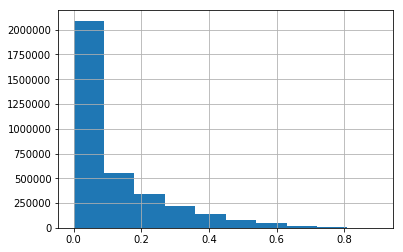

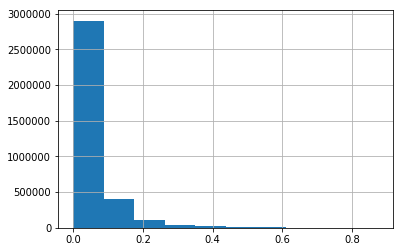

In [34]:
res_df.class_67.hist()
plt.show()
boost_df.class_67.hist()
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdb7a65bcc0>,
      dtype=object)

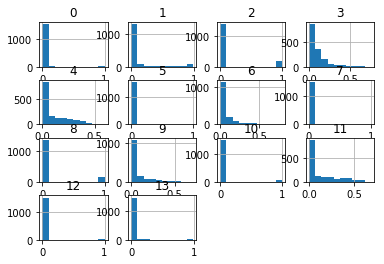

In [176]:
# val の段階ではいい感じに分布してる
pd.DataFrame(torch.nn.functional.softmax(best_val_res).detach().numpy()).hist()

Index(['class_6', 'class_15', 'class_16', 'class_42', 'class_52', 'class_53',
       'class_62', 'class_64', 'class_65', 'class_67', 'class_88', 'class_90',
       'class_92', 'class_95', 'class_99'],
      dtype='object')


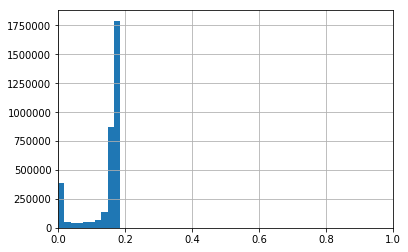

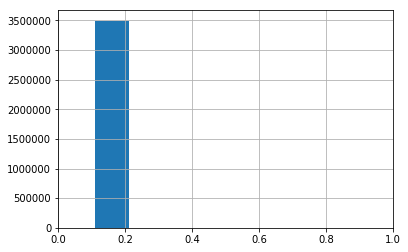

In [54]:
class_num = 99
print(res_df.columns)
res_df[f'class_{class_num}'].hist()
plt.xlim((0, 1))
plt.show()
boost_df[f'class_{class_num}'].hist()
plt.xlim((0, 1))
plt.show()

In [32]:
boost_df = pd.read_csv('../submissions/Booster_weight-multi-logloss-0.579991_2018-11-18-12-47-32.csv')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdb7b1e01d0>,
      dtype=object)

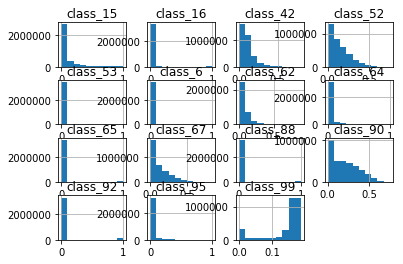

In [164]:
# val の段階ではいい感じに分布してる
pd.DataFrame(res_df).hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7de00836d8>,
      dtype=object)

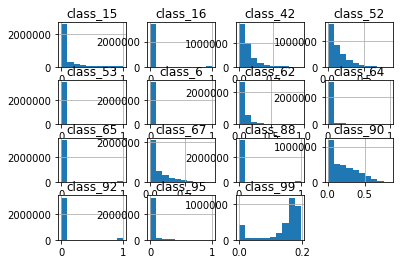

In [31]:
# val の段階ではいい感じに分布してる
pd.DataFrame(res_df).hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fede39b21d0>,
      dtype=object)

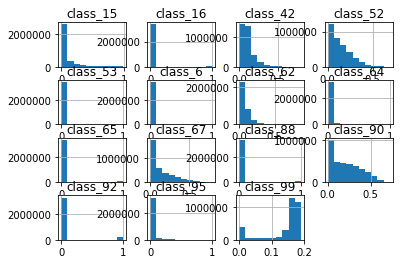

In [175]:
# val の段階ではいい感じに分布してる
pd.DataFrame(res_df).hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7dc00b7e48>,
      dtype=object)

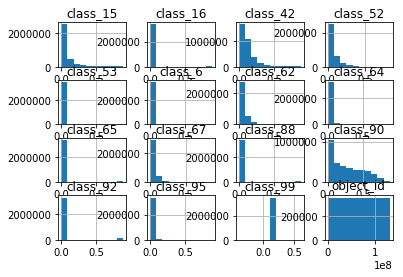

In [33]:
boost_df.hist()

In [1]:
import pandas as pd

In [2]:
meta_df = pd.read_csv('/home/naoya.taguchi/.kaggle/competitions/PLAsTiCC-2018/test_set_metadata.csv')
meta_df

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv
0,13,34.453125,-5.229529,169.987075,-59.956185,1,0.3048,0.3193,0.0542,41.1123,0.019
1,14,33.398438,-4.331149,167.226341,-59.936551,1,NaN,0.6323,0.0179,42.8774,0.018
2,17,348.529419,-61.755440,321.293980,-51.763351,1,NaN,0.8297,0.0605,43.6000,0.016
3,23,34.804688,-5.829153,171.307861,-60.174401,1,NaN,0.6533,0.1479,42.9640,0.023
4,34,351.321442,-64.198746,317.458993,-50.429931,1,0.4557,0.4617,0.0122,42.0540,0.023
5,35,35.332031,-5.979157,172.286722,-59.931743,1,NaN,0.8388,0.0375,43.6290,0.022
6,43,0.574468,-45.981140,327.041068,-68.778764,1,NaN,0.6669,0.0546,43.0186,0.006
7,50,0.574468,-45.981140,327.041068,-68.778764,1,NaN,1.4663,0.0529,45.1281,0.006
8,60,346.562500,-63.448284,320.824720,-49.866957,1,NaN,0.9462,0.0116,43.9519,0.021
9,69,349.160583,-64.760857,318.219706,-49.458924,1,NaN,1.0432,0.1092,44.2138,0.020


In [9]:
#df = pd.read_csv('../submissions/Booster_weight-multi-logloss-0.577933_2018-11-29-20-26-36.csv')
#df = pd.read_csv('../submissions/Booster_weight-multi-logloss-0.566286_2018-12-02-11-58-49.csv')
df = pd.read_csv('../submissions/Booster_weight-multi-logloss-0.565583_2018-12-02-17-18-53.csv')
df

,object_id,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
0,13.0,0.002491,0.002963,0.002380,0.789366,0.123288,0.002847,0.027342,0.002247,0.002556,0.005638,0.002632,0.028795,0.002698,0.004757,0.095510
1,14.0,0.005813,0.173699,0.005550,0.271497,0.062739,0.006640,0.098104,0.009177,0.006161,0.032147,0.008730,0.290256,0.006324,0.023166,0.183737
2,17.0,0.005581,0.067954,0.005566,0.116247,0.041786,0.006518,0.054625,0.032651,0.005934,0.044004,0.018981,0.505758,0.006101,0.088292,0.167255
3,23.0,0.002382,0.003510,0.002371,0.077829,0.017556,0.002827,0.061300,0.004689,0.002514,0.420025,0.004382,0.345575,0.002611,0.052430,0.168460
4,34.0,0.002460,0.004423,0.002422,0.027453,0.063351,0.002847,0.014533,0.002319,0.002711,0.013271,0.002670,0.855420,0.002692,0.003427,0.070487
5,35.0,0.002896,0.005312,0.002847,0.062778,0.019635,0.003345,0.031205,0.005935,0.002978,0.032488,0.004159,0.651673,0.003195,0.171553,0.136143
6,43.0,0.003759,0.005773,0.003820,0.058562,0.037152,0.004468,0.084823,0.011610,0.003991,0.164881,0.006171,0.538131,0.004187,0.072671,0.160417
7,50.0,0.004511,0.051054,0.005777,0.039023,0.022310,0.005308,0.085193,0.335786,0.004408,0.124388,0.010861,0.148483,0.004936,0.157961,0.185353
8,60.0,0.002603,0.004143,0.002550,0.053016,0.007839,0.003062,0.069180,0.004473,0.002532,0.216217,0.003229,0.484216,0.002852,0.144088,0.166642
9,69.0,0.003780,0.009102,0.003722,0.087569,0.024306,0.004366,0.104146,0.006167,0.003696,0.203725,0.005580,0.169405,0.004156,0.370279,0.180158


In [77]:
df = df.iloc[:-2]
df

,object_id,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
0,13.0,0.002654,0.003164,0.002540,0.778176,0.127856,0.002994,0.029391,0.002417,0.002729,0.006272,0.002769,0.030909,0.002867,0.005261,0.099405
1,14.0,0.005645,0.192113,0.005431,0.248032,0.060084,0.006482,0.103673,0.008672,0.006036,0.031362,0.008591,0.290665,0.006172,0.027043,0.184404
2,17.0,0.005718,0.088109,0.005673,0.111422,0.037459,0.006402,0.051755,0.033959,0.005884,0.046657,0.018823,0.503191,0.006018,0.078930,0.167715
3,23.0,0.002535,0.003851,0.002493,0.086873,0.016868,0.002850,0.063342,0.005379,0.002588,0.403690,0.004622,0.346575,0.002665,0.055669,0.170149
4,34.0,0.002372,0.004300,0.002338,0.025364,0.055681,0.002741,0.014477,0.002226,0.002602,0.012409,0.002562,0.866657,0.002592,0.003678,0.065792
5,35.0,0.002908,0.005261,0.002871,0.062704,0.019682,0.003378,0.031663,0.005889,0.003024,0.031268,0.004192,0.655320,0.003205,0.168635,0.135320
6,43.0,0.003712,0.005761,0.003694,0.055490,0.037426,0.004185,0.083574,0.012505,0.003800,0.180769,0.006146,0.529825,0.003952,0.069162,0.161534
7,50.0,0.004727,0.050656,0.005474,0.041766,0.024981,0.005358,0.087075,0.314091,0.004594,0.127435,0.011458,0.150479,0.004977,0.166931,0.186798
8,60.0,0.002470,0.003904,0.002459,0.050686,0.007049,0.002953,0.062911,0.003971,0.002474,0.212252,0.002976,0.463001,0.002726,0.180167,0.168985
9,69.0,0.003455,0.009164,0.003450,0.077414,0.023936,0.004057,0.103567,0.005761,0.003475,0.200091,0.005106,0.160291,0.003825,0.396408,0.177948


In [78]:
df.loc[df[meta_df.distmod.isnull()].index, ['class_15', 'class_42', 'class_52', 'class_62', 'class_64', 'class_67', 'class_88', 'class_90', 'class_95']] = 0.
df.loc[df[meta_df.distmod.notnull()].index, ['class_6', 'class_16', 'class_53', 'class_65', 'class_92']] = 0.
df

/home/naoya.taguchi/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/naoya.taguchi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/naoya.taguchi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,object_id,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
0,13.0,0.000000,0.003164,0.000000,0.778176,0.127856,0.000000,0.029391,0.002417,0.000000,0.006272,0.002769,0.030909,0.000000,0.005261,0.099405
1,14.0,0.000000,0.192113,0.000000,0.248032,0.060084,0.000000,0.103673,0.008672,0.000000,0.031362,0.008591,0.290665,0.000000,0.027043,0.184404
2,17.0,0.000000,0.088109,0.000000,0.111422,0.037459,0.000000,0.051755,0.033959,0.000000,0.046657,0.018823,0.503191,0.000000,0.078930,0.167715
3,23.0,0.000000,0.003851,0.000000,0.086873,0.016868,0.000000,0.063342,0.005379,0.000000,0.403690,0.004622,0.346575,0.000000,0.055669,0.170149
4,34.0,0.000000,0.004300,0.000000,0.025364,0.055681,0.000000,0.014477,0.002226,0.000000,0.012409,0.002562,0.866657,0.000000,0.003678,0.065792
5,35.0,0.000000,0.005261,0.000000,0.062704,0.019682,0.000000,0.031663,0.005889,0.000000,0.031268,0.004192,0.655320,0.000000,0.168635,0.135320
6,43.0,0.000000,0.005761,0.000000,0.055490,0.037426,0.000000,0.083574,0.012505,0.000000,0.180769,0.006146,0.529825,0.000000,0.069162,0.161534
7,50.0,0.000000,0.050656,0.000000,0.041766,0.024981,0.000000,0.087075,0.314091,0.000000,0.127435,0.011458,0.150479,0.000000,0.166931,0.186798
8,60.0,0.000000,0.003904,0.000000,0.050686,0.007049,0.000000,0.062911,0.003971,0.000000,0.212252,0.002976,0.463001,0.000000,0.180167,0.168985
9,69.0,0.000000,0.009164,0.000000,0.077414,0.023936,0.000000,0.103567,0.005761,0.000000,0.200091,0.005106,0.160291,0.000000,0.396408,0.177948


In [79]:
classes = ['class_6', 'class_15', 'class_16', 'class_42', 'class_52', 'class_53', 'class_62', 'class_64', 'class_65', 'class_67', 'class_88', 'class_90', 'class_92', 'class_95']
#df[classes] / df[classes].sum(axis=1)
#df[classes].sum(axis=1)
#df[classes].sum(axis=1)
sum_row =  df[classes].sum(axis=1)
for _class in classes:
    df[_class] = df[_class] / sum_row
df[classes].sum(axis=1)

/home/naoya.taguchi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


0          1.0
1          1.0
2          1.0
3          1.0
4          1.0
5          1.0
6          1.0
7          1.0
8          1.0
9          1.0
10         1.0
11         1.0
12         1.0
13         1.0
14         1.0
15         1.0
16         1.0
17         1.0
18         1.0
19         1.0
20         1.0
21         1.0
22         1.0
23         1.0
24         1.0
25         1.0
26         1.0
27         1.0
28         1.0
29         1.0
          ... 
3492860    1.0
3492861    1.0
3492862    1.0
3492863    1.0
3492864    1.0
3492865    1.0
3492866    1.0
3492867    1.0
3492868    1.0
3492869    1.0
3492870    1.0
3492871    1.0
3492872    1.0
3492873    1.0
3492874    1.0
3492875    1.0
3492876    1.0
3492877    1.0
3492878    1.0
3492879    1.0
3492880    1.0
3492881    1.0
3492882    1.0
3492883    1.0
3492884    1.0
3492885    1.0
3492886    1.0
3492887    1.0
3492888    1.0
3492889    1.0
Length: 3492890, dtype: float64

In [80]:
import numpy as np

res = df[classes].values

preds_99 = np.ones((res.shape[0]))
for i in range(res.shape[1]):
    preds_99 *= (1 - res[:, i])
    
preds_99 = 0.14 * preds_99 / np.mean(preds_99)
preds_99

array([0.08525552, 0.16321387, 0.14711624, ..., 0.16150173, 0.13190837,
       0.0407134 ])

In [81]:
df['class_99'] = preds_99
df['class_99']

/home/naoya.taguchi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0          0.085256
1          0.163214
2          0.147116
3          0.150874
4          0.054422
5          0.118300
6          0.142266
7          0.165673
8          0.149785
9          0.157724
10         0.084159
11         0.119696
12         0.135874
13         0.153959
14         0.163777
15         0.144779
16         0.080373
17         0.133403
18         0.156589
19         0.157894
20         0.008201
21         0.154369
22         0.135558
23         0.107820
24         0.146079
25         0.151340
26         0.152684
27         0.140962
28         0.119466
29         0.153917
             ...   
3492860    0.134223
3492861    0.160036
3492862    0.152235
3492863    0.162231
3492864    0.164582
3492865    0.169606
3492866    0.172379
3492867    0.171243
3492868    0.165063
3492869    0.135471
3492870    0.172505
3492871    0.150818
3492872    0.164487
3492873    0.165769
3492874    0.174095
3492875    0.164841
3492876    0.164957
3492877    0.148510
3492878    0.154776


In [87]:
#df.to_csv('../submissions/Booster_weight-multi-logloss-0.577933_2018-11-29-20-26-36_setzero.csv.gz', compression='gzip', index=False)
#df.to_csv('../submissions/Booster_weight-multi-logloss-0.577933_2018-11-29-20-26-36_setzero.csv', index=False)

df.to_csv('../submissions/Booster_weight-multi-logloss-0.566286_2018-12-02-11-58-49_setzero.csv.gz', compression='gzip', index=False)

In [83]:
df = pd.read_csv('../submissions/Booster_weight-multi-logloss-0.566286_2018-12-02-11-58-49_setzero.csv.gz', compression='gzip' )

In [86]:
df['object_id'] = df.object_id.astype(np.int32)
df

,object_id,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
0,13,0.000000,0.003208,0.000000,0.789053,0.129643,0.000000,0.029802,0.002450,0.000000,0.006360,0.002808,0.031341,0.000000,0.005334,0.085256
1,14,0.000000,0.198007,0.000000,0.255641,0.061927,0.000000,0.106854,0.008938,0.000000,0.032324,0.008855,0.299582,0.000000,0.027873,0.163214
2,17,0.000000,0.090805,0.000000,0.114832,0.038605,0.000000,0.053339,0.034999,0.000000,0.048085,0.019399,0.518590,0.000000,0.081345,0.147116
3,23,0.000000,0.003903,0.000000,0.088029,0.017093,0.000000,0.064185,0.005451,0.000000,0.409062,0.004684,0.351186,0.000000,0.056410,0.150874
4,34,0.000000,0.004355,0.000000,0.025689,0.056394,0.000000,0.014662,0.002254,0.000000,0.012568,0.002595,0.877757,0.000000,0.003726,0.054422
5,35,0.000000,0.005343,0.000000,0.063684,0.019990,0.000000,0.032157,0.005982,0.000000,0.031757,0.004257,0.665561,0.000000,0.171270,0.118300
6,43,0.000000,0.005875,0.000000,0.056585,0.038164,0.000000,0.085222,0.012752,0.000000,0.184335,0.006267,0.540275,0.000000,0.070526,0.142266
7,50,0.000000,0.051961,0.000000,0.042842,0.025624,0.000000,0.089319,0.322187,0.000000,0.130720,0.011754,0.154358,0.000000,0.171234,0.165673
8,60,0.000000,0.003956,0.000000,0.051357,0.007143,0.000000,0.063745,0.004024,0.000000,0.215066,0.003016,0.469139,0.000000,0.182555,0.149785
9,69,0.000000,0.009335,0.000000,0.078854,0.024381,0.000000,0.105494,0.005868,0.000000,0.203813,0.005201,0.163273,0.000000,0.403782,0.157724


In [34]:
np.where(~np.isnan(meta_df.values[:, np.where(meta_df.columns == 'distmod')[0]]))[0].shape

(3102380,)

In [39]:
print(meta_df.values[:, np.where(meta_df.columns == 'distmod')[0]])

[[41.1123]
 [42.8774]
 [43.6   ]
 ...
 [38.7604]
 [41.8625]
 [41.4333]]


In [29]:
gal_cols = []
'class_15', 'class_42', 'class_52', 'class_62', 'class_64', 'class_67', 'class_88', 'class_90', 'class_95'
df.drop('object_id', axis=1)

,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
0,0.000000,0.003854,0.000000,0.757541,0.148584,0.000000,0.027996,0.001862,0.000000,0.006058,0.002385,0.046821,0.000000,0.004901,0.108304
1,0.000000,0.069573,0.000000,0.293300,0.084550,0.000000,0.092506,0.014400,0.000000,0.026068,0.010698,0.373161,0.000000,0.035744,0.180976
2,0.000000,0.029193,0.000000,0.126021,0.048475,0.000000,0.053682,0.084634,0.000000,0.031645,0.021408,0.506177,0.000000,0.098765,0.170236
3,0.000000,0.004055,0.000000,0.120193,0.017667,0.000000,0.064569,0.010884,0.000000,0.415792,0.005952,0.299580,0.000000,0.061309,0.175515
4,0.000000,0.005734,0.000000,0.027542,0.047367,0.000000,0.012139,0.001964,0.000000,0.008405,0.002680,0.890486,0.000000,0.003684,0.056558
5,0.000000,0.005381,0.000000,0.073593,0.023259,0.000000,0.025978,0.006465,0.000000,0.034004,0.005162,0.591879,0.000000,0.234278,0.150972
6,0.000000,0.004186,0.000000,0.051679,0.031432,0.000000,0.068683,0.023900,0.000000,0.178667,0.005478,0.573851,0.000000,0.062124,0.156680
7,0.000000,0.036206,0.000000,0.037124,0.019911,0.000000,0.065038,0.316597,0.000000,0.154842,0.007858,0.173800,0.000000,0.188624,0.188551
8,0.000000,0.003900,0.000000,0.067581,0.008756,0.000000,0.049847,0.005006,0.000000,0.254408,0.003637,0.386577,0.000000,0.220287,0.178501
9,0.000000,0.006540,0.000000,0.078011,0.029227,0.000000,0.086441,0.006723,0.000000,0.142666,0.005550,0.288671,0.000000,0.356170,0.181842


In [46]:
df.values[[0, 1, 2], :]

array([[1.30000000e+01, 0.00000000e+00, 3.85351982e-03, 0.00000000e+00,
        7.57540919e-01, 1.48583832e-01, 0.00000000e+00, 2.79957963e-02,
        1.86213454e-03, 0.00000000e+00, 6.05772668e-03, 2.38473090e-03,
        4.68205216e-02, 0.00000000e+00, 4.90081839e-03, 1.08304377e-01],
       [1.40000000e+01, 0.00000000e+00, 6.95730121e-02, 0.00000000e+00,
        2.93300170e-01, 8.45500860e-02, 0.00000000e+00, 9.25055702e-02,
        1.44003224e-02, 0.00000000e+00, 2.60678997e-02, 1.06978355e-02,
        3.73160987e-01, 0.00000000e+00, 3.57441170e-02, 1.80975935e-01],
       [1.70000000e+01, 0.00000000e+00, 2.91926789e-02, 0.00000000e+00,
        1.26021084e-01, 4.84752546e-02, 0.00000000e+00, 5.36819119e-02,
        8.46342600e-02, 0.00000000e+00, 3.16452497e-02, 2.14079697e-02,
        5.06176574e-01, 0.00000000e+00, 9.87650178e-02, 1.70235548e-01]])

In [5]:
df = pd.read_feather('../test_dfs/test_df_for_nn.fth')
df

,object_id,hostgal_photoz_err,distmod,lumi_dist,flux_min,flux_max,flux_mean,flux_median,flux_std,flux_var,...,internal,c90_z_z1,c90_y_z1,c52_y_z1,c67_g_z2,c67_i_z2,c67_y_z2,c52_r_z3,c42_i_z4,c42_z_z4
0,13,0.0542,41.1123,1.669014e+09,-12.680235,42.765503,3.997127,0.616561,9.149645,8.371600e+01,...,False,9.390269,1.943906,2.993463,1.898032,11.232923,2.344784,6.132683,6.578410,9.933218
1,14,0.0179,42.8774,3.762530e+09,-11.142164,14.839427,0.884047,0.072856,3.399946,1.155963e+01,...,False,NaN,NaN,NaN,0.972816,1.197749,NaN,1.107778,1.070769,NaN
2,17,0.0605,43.6000,5.248075e+09,-14.202744,16.761280,0.791032,0.458391,3.886578,1.510549e+01,...,False,NaN,NaN,NaN,1.361492,1.101139,NaN,1.270988,1.311761,NaN
3,23,0.1479,42.9640,3.915615e+09,-12.631923,28.061138,0.970396,0.465986,4.100713,1.681584e+01,...,False,0.737174,NaN,NaN,NaN,1.653800,NaN,1.146899,1.613232,0.852435
4,34,0.0122,42.0540,2.575135e+09,-13.239577,124.475609,4.580070,0.301366,19.862714,3.945274e+02,...,False,5.367685,2.063274,1.488509,7.534384,20.952691,1.476331,61.873673,17.218760,6.591742
5,35,0.0375,43.6290,5.318633e+09,-9.032743,34.847000,1.800237,0.589795,5.726820,3.279646e+01,...,False,1.500328,0.734977,1.075497,NaN,3.164535,0.975357,1.811993,3.462126,1.307392
6,43,0.0546,43.0186,4.015319e+09,-10.711065,23.771006,0.533671,0.096750,3.428601,1.175530e+01,...,False,NaN,NaN,NaN,NaN,1.508438,NaN,0.930497,1.293318,NaN
7,50,0.0529,45.1281,1.060767e+10,-21.568415,12.179604,0.012805,0.009715,3.409948,1.162774e+01,...,False,NaN,NaN,NaN,NaN,NaN,NaN,1.419350,NaN,NaN
8,60,0.0116,43.9519,6.171347e+09,-21.433050,28.675814,1.480276,0.087896,6.017310,3.620802e+01,...,False,1.260674,NaN,NaN,NaN,1.514927,NaN,1.231022,1.784987,1.186469
9,69,0.1092,44.2138,6.962417e+09,-14.229353,35.446308,1.388202,0.398017,5.941994,3.530729e+01,...,False,1.873220,1.030602,0.985040,NaN,1.318693,0.960344,1.300163,1.912828,1.838702


In [7]:
train_cols = ['hostgal_photoz_err', 'distmod', 'lumi_dist', 'index', 'flux_min', 'flux_max', 'flux_mean', 'flux_median', 'flux_std', 'flux_var', 'flux_skew', 'flux_count', 'flux_kurtosis', 'corrected_flux_min', 'corrected_flux_max', 'corrected_flux_mean', 'corrected_flux_median', 'corrected_flux_std', 'corrected_flux_var', 'corrected_flux_skew', 'flux_err_min', 'flux_err_max', 'flux_err_mean', 'flux_err_median', 'flux_err_std', 'flux_err_var', 'flux_err_skew', 'flux_err_kurtosis', 'flux_ratio_to_flux_err_min', 'flux_ratio_to_flux_err_max', 'detected_mean', 'flux_ratio_sq_skew', 'flux_ratio_sq_mean', 'flux_ratio_sq_kurtosis', 'flux_by_flux_ratio_sq_sum', 'flux_by_flux_ratio_sq_skew', 'corrected_flux_ratio_sq_sum', 'corrected_flux_ratio_sq_skew', 'corrected_flux_by_flux_ratio_sq_sum', 'corrected_flux_by_flux_ratio_sq_skew', 'std_upper_mjd_get_max_min_diff', 'std_upper_mjd_var', 'std_upper_mjd_skew', 'std_upper_flux_count', 'std_upper_flux_min', 'detected_mjd_get_max_min_diff', 'detected_mjd_skew', 'band-0_wmean', 'band-0_normed_std', 'band-0_normed_amp', 'band-0_normed_mad', 'band-0_beyond_1std', 'band-0_flux_var', 'band-0_flux_skew', 'band-0_flux_kurtosis', 'band-0_flux_quantile10', 'band-0_flux_quantile25', 'band-0_flux_quantile75', 'band-0_flux_quantile90', 'band-0_flux_quantile2575_range', 'band-0_flux_quantile1090_range', 'band-0_normed_flux_diff_mean', 'band-0_detected_mean', 'band-0_flux_ratio_sq_sum', 'band-0_flux_ratio_sq_skew', 'band-0_flux_by_flux_ratio_sq_sum', 'band-0_flux_by_flux_ratio_sq_skew', 'band-0_flux_diff', 'band-0_std_upper_mjd_get_max_min_diff', 'band-0_std_upper_mjd_var', 'band-0_std_upper_mjd_skew', 'band-0_std_upper_mjd_diff_mean', 'band-0_std_upper_flux_count', 'band-0_std_upper_flux_diff_mean', 'band-1_wmean', 'band-1_normed_std', 'band-1_normed_amp', 'band-1_normed_mad', 'band-1_beyond_1std', 'band-1_flux_var', 'band-1_flux_skew', 'band-1_flux_kurtosis', 'band-1_flux_quantile10', 'band-1_flux_quantile25', 'band-1_flux_quantile75', 'band-1_flux_quantile90', 'band-1_flux_quantile2575_range', 'band-1_flux_quantile1090_range', 'band-1_normed_flux_diff_mean', 'band-1_detected_mean', 'band-1_flux_ratio_sq_sum', 'band-1_flux_ratio_sq_skew', 'band-1_flux_by_flux_ratio_sq_sum', 'band-1_flux_by_flux_ratio_sq_skew', 'band-1_flux_diff', 'band-1_std_upper_mjd_get_max_min_diff', 'band-1_std_upper_mjd_var', 'band-1_std_upper_mjd_skew', 'band-1_std_upper_mjd_diff_mean', 'band-1_std_upper_flux_count', 'band-1_std_upper_flux_diff_mean', 'band-2_wmean', 'band-2_normed_std', 'band-2_normed_amp', 'band-2_normed_mad', 'band-2_beyond_1std', 'band-2_flux_var', 'band-2_flux_skew', 'band-2_flux_kurtosis', 'band-2_flux_quantile10', 'band-2_flux_quantile25', 'band-2_flux_quantile75', 'band-2_flux_quantile90', 'band-2_flux_quantile2575_range', 'band-2_flux_quantile1090_range', 'band-2_normed_flux_diff_mean', 'band-2_detected_mean', 'band-2_flux_ratio_sq_sum', 'band-2_flux_ratio_sq_skew', 'band-2_flux_by_flux_ratio_sq_sum', 'band-2_flux_by_flux_ratio_sq_skew', 'band-2_flux_diff', 'band-2_std_upper_mjd_get_max_min_diff', 'band-2_std_upper_mjd_var', 'band-2_std_upper_mjd_skew', 'band-2_std_upper_mjd_diff_mean', 'band-2_std_upper_flux_count', 'band-2_std_upper_flux_diff_mean', 'band-3_wmean', 'band-3_normed_std', 'band-3_normed_amp', 'band-3_normed_mad', 'band-3_beyond_1std', 'band-3_flux_var', 'band-3_flux_skew', 'band-3_flux_kurtosis', 'band-3_flux_quantile10', 'band-3_flux_quantile25', 'band-3_flux_quantile75', 'band-3_flux_quantile90', 'band-3_flux_quantile2575_range', 'band-3_flux_quantile1090_range', 'band-3_normed_flux_diff_mean', 'band-3_detected_mean', 'band-3_flux_ratio_sq_sum', 'band-3_flux_ratio_sq_skew', 'band-3_flux_by_flux_ratio_sq_sum', 'band-3_flux_by_flux_ratio_sq_skew', 'band-3_flux_diff', 'band-3_std_upper_mjd_get_max_min_diff', 'band-3_std_upper_mjd_var','band-3_std_upper_mjd_skew', 'band-3_std_upper_mjd_diff_mean', 'band-3_std_upper_flux_count', 'band-3_std_upper_flux_diff_mean', 'band-4_wmean', 'band-4_normed_std', 'band-4_normed_amp', 'band-4_normed_mad', 'band-4_beyond_1std', 'band-4_flux_var', 'band-4_flux_skew', 'band-4_flux_kurtosis', 'band-4_flux_quantile10', 'band-4_flux_quantile25', 'band-4_flux_quantile75', 'band-4_flux_quantile90', 'band-4_flux_quantile2575_range', 'band-4_flux_quantile1090_range', 'band-4_normed_flux_diff_mean', 'band-4_detected_mean', 'band-4_flux_ratio_sq_sum', 'band-4_flux_ratio_sq_skew', 'band-4_flux_by_flux_ratio_sq_sum', 'band-4_flux_by_flux_ratio_sq_skew', 'band-4_flux_diff', 'band-4_std_upper_mjd_get_max_min_diff','band-4_std_upper_mjd_var', 'band-4_std_upper_mjd_skew', 'band-4_std_upper_mjd_diff_mean', 'band-4_std_upper_flux_count', 'band-4_std_upper_flux_diff_mean', 'band-5_wmean', 'band-5_normed_std', 'band-5_normed_amp', 'band-5_normed_mad', 'band-5_beyond_1std', 'band-5_flux_var', 'band-5_flux_skew', 'band-5_flux_kurtosis', 'band-5_flux_quantile10', 'band-5_flux_quantile25', 'band-5_flux_quantile75', 'band-5_flux_quantile90', 'band-5_flux_quantile2575_range', 'band-5_flux_quantile1090_range', 'band-5_normed_flux_diff_mean', 'band-5_detected_mean', 'band-5_flux_ratio_sq_sum', 'band-5_flux_ratio_sq_skew', 'band-5_flux_by_flux_ratio_sq_sum', 'band-5_flux_by_flux_ratio_sq_skew', 'band-5_flux_diff', 'band-5_std_upper_mjd_get_max_min_diff', 'band-5_std_upper_mjd_var', 'band-5_std_upper_mjd_skew', 'band-5_std_upper_mjd_diff_mean', 'band-5_std_upper_flux_count', 'band-5_std_upper_flux_diff_mean', '0_minus_1_wmean', '0_minus_1_std', '0_minus_1_amp', '1_minus_2_wmean', '1_minus_2_std', '1_minus_2_amp', '2_minus_3_wmean', '2_minus_3_std', '2_minus_3_amp', '3_minus_4_wmean', '3_minus_4_std', '3_minus_4_amp', '4_minus_5_wmean', '4_minus_5_std', '4_minus_5_amp', '5_minus_0_wmean', '5_minus_0_std', '5_minus_0_amp', 'flux_diff', 'flux_dif2', 'flux_w_mean', 'flux_dif3', 'corrected_flux_diff', 'corrected_flux_dif2', 'corrected_flux_w_mean', 'corrected_flux_dif3', 'std_upper_rat', 'band-0_flux_max_ratio_to_the_max', 'band-1_flux_max_ratio_to_the_max', 'band-2_flux_max_ratio_to_the_max', 'band-3_flux_max_ratio_to_the_max', 'band-4_flux_max_ratio_to_the_max', 'band-5_flux_max_ratio_to_the_max', 'passband_flux_min_var', 'passband_flux_means_var', 'passband_flux_counts_var', 'passband_detected_means_var', 'band_flux_diff_max', 'band_flux_diff_min', 'band_flux_diff_diff', 'band_flux_diff_diff_rat', 'band_flux_max_min_rat', '0__length', '0__longest_strike_above_mean', '0__longest_strike_below_mean', '0__mean_abs_change', '0__mean_change', '1__length', '1__longest_strike_above_mean', '1__longest_strike_below_mean', '1__mean_abs_change', '1__mean_change', '2__length', '2__longest_strike_above_mean', '2__longest_strike_below_mean', '2__mean_abs_change', '2__mean_change', '3__length', '3__longest_strike_above_mean', '3__longest_strike_below_mean', '3__mean_abs_change', '3__mean_change', '4__length', '4__longest_strike_above_mean', '4__longest_strike_below_mean', '4__mean_abs_change', '4__mean_change', '5__length', '5__longest_strike_above_mean', '5__longest_strike_below_mean', '5__mean_abs_change', '5__mean_change', 'internal', 'c90_z_z1', 'c90_y_z1', 'c52_y_z1', 'c67_g_z2', 'c67_i_z2', 'c67_y_z2', 'c52_r_z3', 'c42_i_z4', 'c42_z_z4']
for tr, te in zip(train_cols, df.columns.tolist()):
    print(tr, te)

hostgal_photoz_err object_id
distmod hostgal_photoz_err
lumi_dist distmod
index lumi_dist
flux_min flux_min
flux_max flux_max
flux_mean flux_mean
flux_median flux_median
flux_std flux_std
flux_var flux_var
flux_skew flux_skew
flux_count flux_count
flux_kurtosis flux_kurtosis
corrected_flux_min corrected_flux_min
corrected_flux_max corrected_flux_max
corrected_flux_mean corrected_flux_mean
corrected_flux_median corrected_flux_median
corrected_flux_std corrected_flux_std
corrected_flux_var corrected_flux_var
corrected_flux_skew corrected_flux_skew
flux_err_min flux_err_min
flux_err_max flux_err_max
flux_err_mean flux_err_mean
flux_err_median flux_err_median
flux_err_std flux_err_std
flux_err_var flux_err_var
flux_err_skew flux_err_skew
flux_err_kurtosis flux_err_kurtosis
flux_ratio_to_flux_err_min flux_ratio_to_flux_err_min
flux_ratio_to_flux_err_max flux_ratio_to_flux_err_max
detected_mean detected_mean
flux_ratio_sq_skew flux_ratio_sq_skew
flux_ratio_sq_mean flux_ratio_sq_mean
flux_rat

In [94]:
set(df.columns.tolist()) - set(train_cols)

{'level_0'}

In [6]:
import pickle
#with open('../lcfit/LCfit_features_train_20181129.pkl', 'rb') as fin:
with open('../lcfit/LCfit_features_test_20181130.pkl', 'rb') as fin:
    lc_df = pickle.load(fin)
lc_df    

,object_id,c90_z_z1,c90_y_z1,c52_y_z1,c67_g_z2,c67_i_z2,c67_y_z2,c52_r_z3,c42_i_z4,c42_z_z4
1,13,9.390269,1.943906,2.993463,1.898032,11.232923,2.344784,6.132683,6.578410,9.933218
2,14,NaN,NaN,NaN,0.972816,1.197749,NaN,1.107778,1.070769,NaN
3,17,NaN,NaN,NaN,1.361492,1.101139,NaN,1.270988,1.311761,NaN
4,23,0.737174,NaN,NaN,NaN,1.653800,NaN,1.146899,1.613232,0.852435
5,34,5.367685,2.063274,1.488509,7.534384,20.952691,1.476331,61.873673,17.218760,6.591742
6,35,1.500328,0.734977,1.075497,NaN,3.164535,0.975357,1.811993,3.462126,1.307392
7,43,NaN,NaN,NaN,NaN,1.508438,NaN,0.930497,1.293318,NaN
8,50,NaN,NaN,NaN,NaN,NaN,NaN,1.419350,NaN,NaN
9,60,1.260674,NaN,NaN,NaN,1.514927,NaN,1.231022,1.784987,1.186469
10,69,1.873220,1.030602,0.985040,NaN,1.318693,0.960344,1.300163,1.912828,1.838702


In [112]:
trn_meta_df = pd.read_csv('/home/naoya.taguchi/.kaggle/competitions/PLAsTiCC-2018/training_set_metadata.csv')
trn_meta_df

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90
5,1227,35.683594,-5.379379,171.992947,-59.253501,1,0.0000,0.0000,0.0000,NaN,0.020,65
6,1598,347.846710,-64.760857,318.929827,-49.143596,1,0.1352,0.1820,0.0304,39.7279,0.019,90
7,1632,348.595886,-63.072620,320.023289,-50.713060,1,0.6857,0.7014,0.0100,43.1524,0.021,42
8,1920,149.414062,3.433834,234.919132,42.245550,1,0.3088,0.3229,0.3360,41.1401,0.027,90
9,1926,149.414062,1.940072,236.565366,41.393323,1,0.0000,0.0000,0.0000,NaN,0.018,65


In [116]:
set(meta_df.object_id.tolist()) - set(lc_df.object_id.tolist()) 

{104853812}

In [10]:
lc_df[lc_df.object_id.isin([316251, 1171843, 104853812])]
#meta_df

,object_id,c90_z_z1,c90_y_z1,c52_y_z1,c67_g_z2,c67_i_z2,c67_y_z2,c52_r_z3,c42_i_z4,c42_z_z4
30321,316251,4.650208,2.927517,3.667827,2.381219,10.800067,3.734305,9.807716,7.234254,5.668269
729552,1171843,NaN,0.945728,0.979031,NaN,8.790004,0.950105,1.248422,4.627052,NaN
729554,1171843,NaN,NaN,NaN,NaN,15.549649,NaN,0.906817,14.418170,NaN


In [8]:
df[df.object_id == 1171843]

,object_id,hostgal_photoz_err,distmod,lumi_dist,flux_min,flux_max,flux_mean,flux_median,flux_std,flux_var,...,internal,c90_z_z1,c90_y_z1,c52_y_z1,c67_g_z2,c67_i_z2,c67_y_z2,c52_r_z3,c42_i_z4,c42_z_z4
37560,1171843,0.9714,39.9601,9.817932e+08,-43.239304,87.945724,12.587251,6.528358,24.75865,612.990756,...,False,NaN,0.945728,0.979031,NaN,8.790004,0.950105,1.248422,4.627052,NaN
37561,1171843,0.9714,39.9601,9.817932e+08,-43.239304,87.945724,12.587251,6.528358,24.75865,612.990756,...,False,NaN,NaN,NaN,NaN,15.549649,NaN,0.906817,14.418170,NaN
